# **Section 1 — Project Overview: Recipe Rating Predictor**

The goal of this project is to build a **recipe-rating predictor** that estimates how a user would rate a recipe on a **1–5 star scale**, using the Food.com Recipes and Interactions dataset from Kaggle.

This dataset includes:

- **231,637 raw recipes** with text, nutrition, ingredients, and cooking steps  
- **~1.1 million user–recipe interactions** (ratings, timestamps, reviews)  
- **Preprocessed datasets**:
  - **PP_recipes**  
    - Tokenized ingredients  
    - Cooking techniques  
    - Nutrition features (calories, fat, sugar, etc.)  
    - Mapped ingredient IDs  
  - **PP_users**  
    - User histories  
    - Techniques and ingredients frequently used  
  - And more, that will be explored in depth in Section 2. 

---








## **1.1 Predictive Task**

The supervised learning task is:

### Given a user embedding and a recipe embedding, predict the rating that the user would assign to that recipe.

This can be seen as similar to to the "Rating Prediction" task in Assignment 1 of this class. 

---

## **Potential Model Inputs**

### **Recipe Embedding**

Constructed using:
- Tokenized ingredient lists, either via the pre-processed dataset or another method
- Nutrition features (calories, protein, fat, sugar)  
- Cooking techniques extracted from instructions  
- Dimensionality-reduced embeddings (SVD/PCA)

### **User Embedding**

Constructed using:
- Weighted average of past recipe embeddings  
- Rating-based weights (optional)  
- Frequent ingredients or techniques  
- Metadata from PP_users  

---

## **Model Output**

A continuous rating prediction:

$\hat{y} \in [1,5]$

This is a **supervised regression problem**, compatible with:
- Linear Regression  
- k-NN Regression  
- Latent Factor Model
- Baseline heuristics (global mean, recipe mean, user mean)  

---

# **1.2 Evaluation Strategy**


## **Train–Test Setup**

- Utilize the train, test, validation split already created by Kaggle

---

## **Evaluation Metrics**

### **RMSE — Root Mean Squared Error**
- Heavily penalizes large mistakes  
- Benchmark metric in recommender systems  

### **MAE — Mean Absolute Error**
- Interpretable: “on average, the model is off by X stars”  
- Robust to outliers

Together, RMSE and MAE capture:
- **Average prediction error** (MAE)  
- **Sensitivity to large deviations** (RMSE)


---

# **1.3 Baseline Models**

To ensure the model meaningfully improves over simple heuristics, we include several baseline predictors.

### **Baseline 1 — Global Mean Predictor**

$\hat{y} = \bar{r}$

Predicts the overall mean rating for every user–recipe pair.

### **Baseline 2 — Recipe Mean Predictor**

$\hat{y}_{u,i} = \bar{r}_i$

Predicts how recipe *i* is typically rated.  
Strong baseline since some recipes are universally liked/disliked.

### **Baseline 3 — User Mean Predictor**

$\hat{y}_{u,i} = \bar{r}_u$


Models each user's average generosity or strictness.

---

# **1.4 Assessing the Validity of Predictions**

A. **Quantitative Validity**

We will begin by comparing all models using **RMSE** and **MAE** on a held-out test set.  
These metrics allow us to measure average prediction error, penalize large deviations, and determine whether more sophisticated models offer improvements over the baselines.  
This quantitative comparison forms the foundation of our evaluation strategy.

---

B. **Distributional Validity**

To ensure that the model generates realistic rating outputs, we will examine how the distribution of **predicted ratings** compares to the distribution of **true ratings**.  
This will help identify issues such as prediction collapse toward the mean or an inability to represent the full 1–5 rating range.

---

C. **Prediction Behavior Across Rating Levels**

We will use diagnostic plots—such as **predicted-vs-true scatterplots** and **residual plots**—to examine how the model behaves at different rating levels.  
These visualizations will help us check for systematic overprediction or underprediction, especially at the extremes of the rating scale, and reveal whether the model is sensitive to the full range of user–recipe interactions.

---

D. **Calibration of Predictions**

Finally, we will evaluate **calibration** by examining how the average predicted rating compares to the true rating for each rating level.  
A well-calibrated model should produce predictions that meaningfully track true user behavior, providing confidence that the model’s numerical outputs are interpretable.


---

# Section 2: Exploratory analysis, data collection, pre-processing, and discussion


## **2.1 Context**

The dataset used in this project is the **Food.com Recipes and Interactions Dataset**, originally collected from Food.com (formerly GeniusKitchen). It contains:

- **231,637 raw recipes**
- **~1.1 million user–recipe interactions** (ratings, reviews, timestamps)
- **18 years of historical data** (1999–2018)

This dataset was introduced in the research paper:

**Majumder, Li, Ni, & McAuley (EMNLP 2019)**  
*Generating Personalized Recipes from Historical User Preferences*

---

## **Dataset Structure**

### **1. RAW Files**

- `RAW_recipes.csv`  
- `RAW_interactions.csv`  

These contain:
- Original scraped text  
- Metadata  
- Ingredient lists  
- Cooking steps  
- User reviews  

### **2. Preprocessed (PP) Files**

- `PP_recipes.csv`  
- `PP_users.csv`  

These are aligned for ML tasks and include:
- GPT-tokenized names, ingredients, and steps  
- One-hot encoded cooking techniques  
- Ingredient ID lists  
- Per-user sequences of viewed items and ratings  
- Calorie-level labels  

---

## **2.2 Additional Pre-Processing**

While the dataset already contains some pre processed columns, we would like to add additional columns that may be useful for feature engineering down the line. 


### Load all files

In [186]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

pp_recipes = pd.read_csv("data/PP_recipes.csv")
pp_users = pd.read_csv("data/PP_users.csv")
raw_recipes = pd.read_csv("data/RAW_recipes.csv")
raw_interactions = pd.read_csv("data/RAW_interactions.csv")
ingr_map = pd.read_pickle("data/ingr_map.pkl")


### Converting String-Encoded Lists to Python Objects

Many PP columns contain lists stored as strings (e.g., "[1, 2, 3]"). This is essential before computing statistics or building embeddings. We convert them into actual Python lists:

In [187]:
list_cols = ["name_tokens", "ingredient_tokens", "steps_tokens",
             "techniques", "ingredient_ids"]

for col in list_cols:
    pp_recipes[col] = pp_recipes[col].apply(ast.literal_eval)


For PP_users:

In [188]:
user_list_cols = ["techniques", "items", "ratings"]

for col in user_list_cols:
    pp_users[col] = pp_users[col].apply(ast.literal_eval)


## Recipe-Level Exploratory Analysis / Preprocessing

### Ingredient Count per Recipe

We compute and visualize the number of ingredients:

Text(0, 0.5, 'Count')

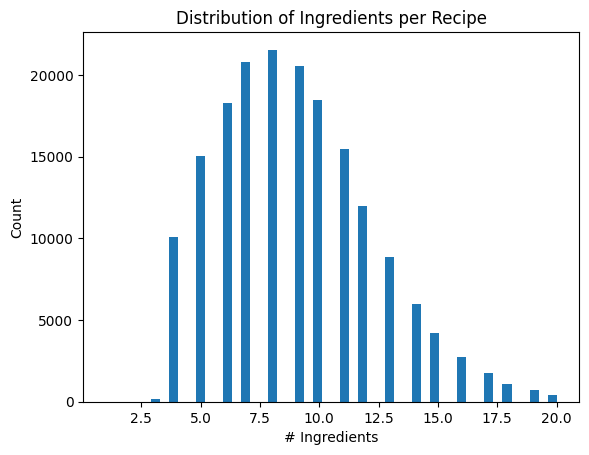

In [189]:
pp_recipes["n_ingredients"] = pp_recipes["ingredient_ids"].apply(len)

plt.hist(pp_recipes["n_ingredients"], bins=50)
plt.title("Distribution of Ingredients per Recipe")
plt.xlabel("# Ingredients"); plt.ylabel("Count")


**Findings**: Most recipes contain between 5–12 ingredients, with a long tail for more complex dishes.

### Cooking Technique Frequencies

The original PP files have techniques as a one-hot encoded vector. We found the original list of techniques (in order) from the Kaggle poster's github repo, to decode the techniques. This is for us to gain a better understanding of what the data actually contains. 

In [190]:
# Techniques - ordered!
TECHNIQUES_LIST = [
    'bake',
    'barbecue',
    'blanch',
    'blend',
    'boil',
    'braise',
    'brine',
    'broil',
    'caramelize',
    'combine',
    'crock pot',
    'crush',
    'deglaze',
    'devein',
    'dice',
    'distill',
    'drain',
    'emulsify',
    'ferment',
    'freez',
    'fry',
    'grate',
    'griddle',
    'grill',
    'knead',
    'leaven',
    'marinate',
    'mash',
    'melt',
    'microwave',
    'parboil',
    'pickle',
    'poach',
    'pour',
    'pressure cook',
    'puree',
    'refrigerat',
    'roast',
    'saute',
    'scald',
    'scramble',
    'shred',
    'simmer',
    'skillet',
    'slow cook',
    'smoke',
    'smooth',
    'soak',
    'sous-vide',
    'steam',
    'stew',
    'strain',
    'tenderize',
    'thicken',
    'toast',
    'toss',
    'whip',
    'whisk',
]

In [191]:
tech_counts = {}

for row in pp_recipes["techniques"]:
    for i, val in enumerate(row):
        if val == 1:
            tech_counts[i] = tech_counts.get(i, 0) + 1

tech_counts = dict(sorted(tech_counts.items(), key=lambda x: -x[1]))

top_n = 10

for idx, count in list(tech_counts.items())[:top_n]:
    technique = TECHNIQUES_LIST[idx]
    print(f"{technique}: {count}")

bake: 64821
combine: 60136
pour: 48747
boil: 42354
melt: 30865
drain: 29567
blend: 29387
simmer: 29380
skillet: 26825
refrigerat: 20543


Text(0, 0.5, 'Count')

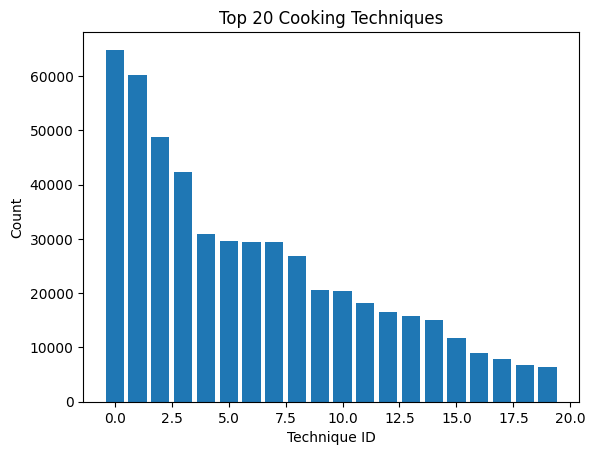

In [192]:
plt.bar(range(20), list(tech_counts.values())[:20])
plt.title("Top 20 Cooking Techniques")
plt.xlabel("Technique ID"); plt.ylabel("Count")

### Step Count Distribution

Text(0, 0.5, 'Count')

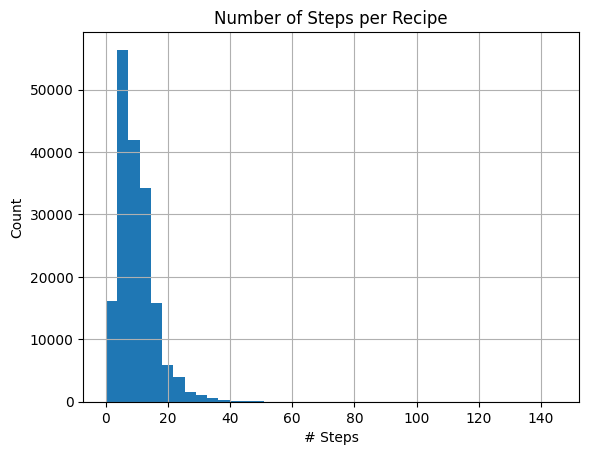

In [193]:
pp_recipes["n_steps"] = raw_recipes["n_steps"]

pp_recipes["n_steps"].hist(bins=40)
plt.title("Number of Steps per Recipe")
plt.xlabel("# Steps"); plt.ylabel("Count")


**Findings**: Most recipes contain 5–9 steps. But there seems to be some outliers.

### Nutrition Processing (RAW → PP)

The RAW nutrition field contains lists of the form "[100.0, 5.0, 10.0, 20.0, 7.0, 2.0, 15.0]"

We parse and expand into named columns:

In [194]:
raw_recipes["nutrition"] = raw_recipes["nutrition"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

nutrition_cols = [
    "calories","total_fat_PDV","sugar_PDV","sodium_PDV",
    "protein_PDV","saturated_fat_PDV","carbs_PDV"
]

nut_df = pd.DataFrame(raw_recipes["nutrition"].tolist(), columns=nutrition_cols)
raw_recipes = pd.concat([raw_recipes.drop(columns=["nutrition"]), nut_df], axis=1)


Then merge back into PP_recipes:

In [195]:
pp_recipes = pp_recipes.merge(
    raw_recipes[["id"] + nutrition_cols], how="left", on="id"
)


In [196]:
pp_recipes.head(1)

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids,n_ingredients,n_steps,calories,total_fat_PDV,sugar_PDV,sodium_PDV,protein_PDV,saturated_fat_PDV,carbs_PDV
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]",5,11,228.2,2.0,2.0,8.0,9.0,1.0,15.0


### Nutrition EDA

Text(0.5, 0.98, 'Nutrition Feature Distributions')

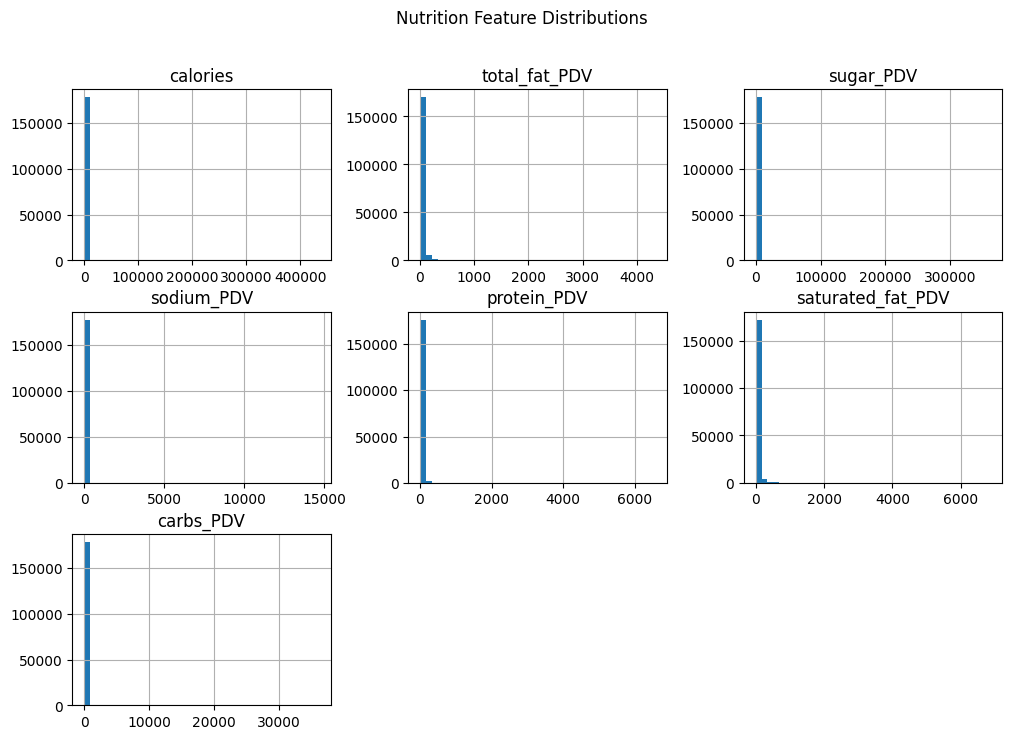

In [197]:
pp_recipes[nutrition_cols].hist(bins=40, figsize=(12,8))
plt.suptitle("Nutrition Feature Distributions")

### Standardization + PCA Visualization

To inspect high-level structure:

Text(0, 0.5, 'PC 2')

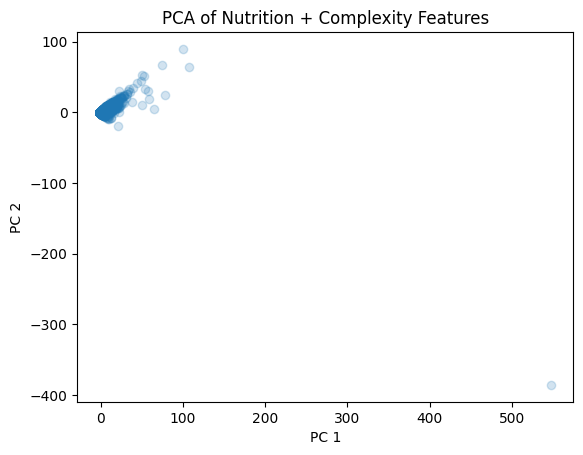

In [198]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = nutrition_cols + ["n_ingredients","n_steps"]
X = pp_recipes[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

plt.scatter(pc[:,0], pc[:,1], alpha=0.2)
plt.title("PCA of Nutrition + Complexity Features")
plt.xlabel("PC 1"); plt.ylabel("PC 2")


## User-Level Exploratory Analysis / Preprocessing

### Mean Rating per User

Text(0.5, 0, 'Mean Rating')

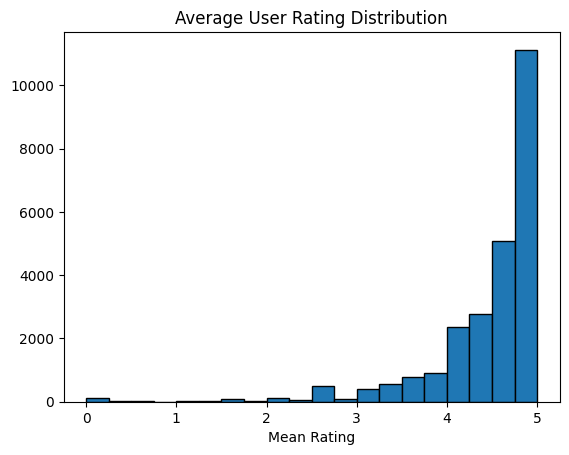

In [199]:
pp_users["mean_rating"] = pp_users["ratings"].apply(
    lambda lst: np.mean(lst) if len(lst) > 0 else np.nan
)

plt.hist(pp_users["mean_rating"].dropna(), bins=20, edgecolor="black")
plt.title("Average User Rating Distribution")
plt.xlabel("Mean Rating")


**Findings**: Most users give ratings between 4–5 stars. There is a strong positive bias.

### User Rating Variance

Users differ in consistency. Some always give 5s, some are picky.

Text(0.5, 0, 'Variance')

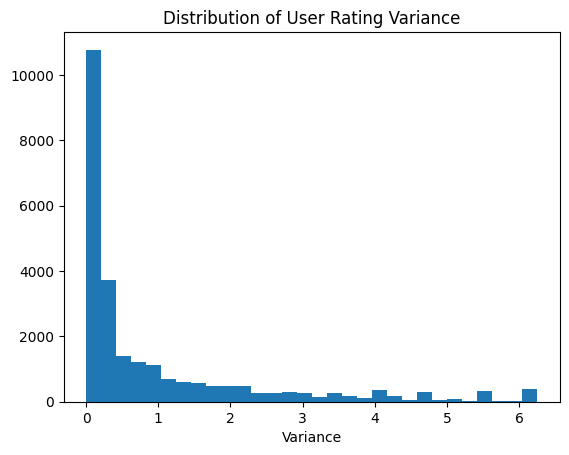

In [200]:
pp_users["rating_variance"] = pp_users["ratings"].apply(
    lambda lst: np.var(lst) if len(lst) > 1 else 0
)

plt.hist(pp_users["rating_variance"], bins=30)
plt.title("Distribution of User Rating Variance")
plt.xlabel("Variance")

### Rating Generosity Score

Normalize user mean rating relative to the global mean.

Who are strict raters (generosity < 0)

Who are inflated raters (generosity > 0)

Text(0.5, 1.0, 'User Rating Generosity Score')

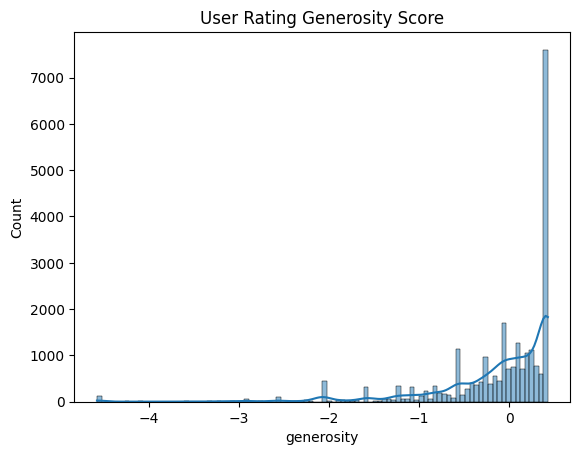

In [201]:
global_mean = np.mean(np.concatenate(pp_users["ratings"].values))
pp_users["generosity"] = pp_users["mean_rating"] - global_mean

sns.histplot(pp_users["generosity"], kde=True)
plt.title("User Rating Generosity Score")

### Technique Diversity per User

Some users cook a wide variety of techniques; others only bake.

Text(0.5, 1.0, 'Technique Diversity per User')

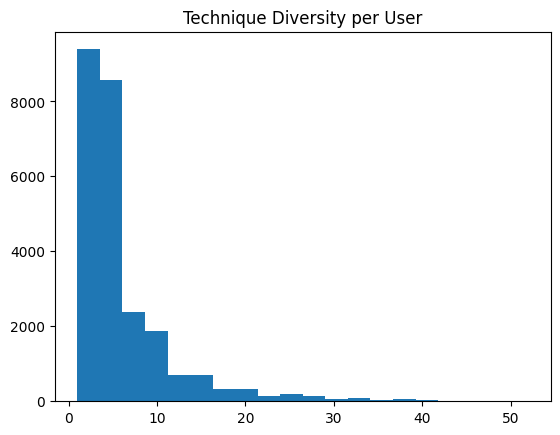

In [202]:
pp_users["technique_diversity"] = pp_users["techniques"].apply(lambda lst: len(set(lst)))

plt.hist(pp_users["technique_diversity"], bins=20)
plt.title("Technique Diversity per User")


### User Activity Distribution

Text(0.5, 0, '# Interactions')

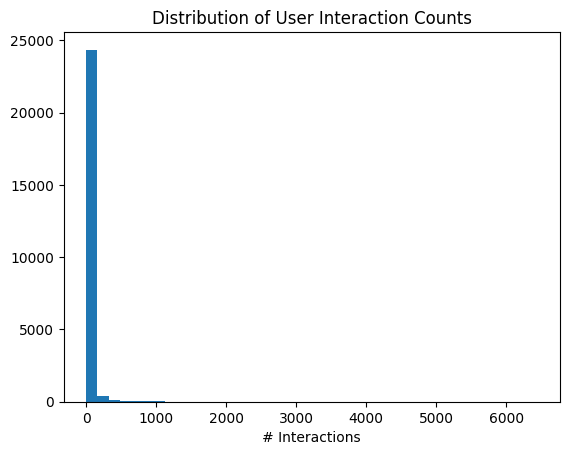

In [203]:
plt.hist(pp_users["n_items"], bins=40)
plt.title("Distribution of User Interaction Counts")
plt.xlabel("# Interactions")


**Findings**: There seems to be a few users that have a very high number of interactions.

In [204]:
upper_bound = pp_users["n_items"].quantile(0.99)
outliers = pp_users[pp_users["n_items"] > upper_bound]

print("Power Users:", len(outliers))
print(outliers.sort_values("n_items", ascending=False).head())

Power Users: 251
       u                                         techniques  \
94    94  [2508, 26, 18, 1319, 1516, 1, 5, 123, 29, 2488...   
275  275  [977, 19, 15, 772, 981, 2, 9, 164, 28, 1556, 3...   
193  193  [997, 46, 2, 531, 613, 2, 3, 144, 21, 1206, 33...   
241  241  [1112, 15, 12, 638, 979, 2, 0, 72, 11, 1180, 3...   
208  208  [1175, 27, 6, 631, 713, 2, 1, 76, 22, 1187, 22...   

                                                 items  n_items  \
94   [91791, 3798, 150824, 101819, 32984, 137191, 1...     6437   
275  [149428, 147083, 83459, 11578, 70918, 78548, 8...     4581   
193  [135512, 164305, 41269, 133049, 134610, 85304,...     3656   
241  [76442, 164837, 5559, 149181, 3020, 39614, 148...     3465   
208  [48637, 136663, 97290, 45833, 161663, 26019, 1...     3338   

                                               ratings  n_ratings  \
94   [4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...       6437   
275  [5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...       45

# Section 3: Modeling

## **3.1 Context: Formulating the Predictive Task**

We model the task as a **supervised regression problem**:

> **Given a user–recipe pair \((u, i)\), predict the rating \(r_{ui} \in [1,5]\) that the user would assign to that recipe.**

This aligns with:
- The dataset’s structure  
- Classical recommender system tasks (e.g., Netflix Prize)  
- The rating prediction assignment covered in class  

## **Inputs**

Preprocessing provides the following:

### **Recipe Embeddings**
Built using fields from **PP_recipes**:
- `ingredient_ids`
- `techniques` (one-hot vector)
- Nutrition features (calories, fat, sugar, etc.)
- `n_ingredients`, `n_steps` extracted in Section 2

These components are combined into a **numerical recipe vector**.

### **User Embeddings**
From **PP_users** we have:
- History of interacted items  
- Past ratings  
- User-level stats (technique_diversity, mean_rating, generosity, etc.)

We construct a **user embedding** as weighted average of past recipe embeddings optionally weighted by user ratings.

---

## **3.2 Models we can implement**


## **Baseline Models**

### Baseline 1 — Global Mean

$$
\hat{r}_{u,i} = \bar{r}
$$

### Baseline 2 — Recipe Mean

$$
\hat{r}_{u,i} = \bar{r}_i
$$


### Baseline 3 — User Mean

$$
\hat{r}_{u,i} = \bar{r}_u
$$

These baselines:
- Are fast and simple  
- Provide strong reference points  
- Show whether our ML models add real value  


## **Classical ML Models**

### k-NN Regression

We train k-NN on the concatenated embedding vector:

$$
x_{u,i} = [\text{user\_embedding}_u \;||\; \text{recipe\_embedding}_i]
$$

**Advantages**
- Non-parametric  
- Captures nonlinear patterns  
- Easy to implement  

**Disadvantages**
- Slow inference  
- Sensitive to feature scaling  
- Suffers in high dimensions  


### Linear Regression / Ridge Regression

$$
\hat{r}_{u,i} = w^\top x_{u,i} + b
$$

**Advantages**
- Interpretable coefficients  
- Very fast to train  
- Matches course assignments  

**Disadvantages**
- Only models linear relationships  
- Requires scaling of features  


## **Advanced Model**

### Matrix Factorization (Latent Factor Model)

$$
\hat{r}_{u,i}
= \mu + b_u + b_i + p_u^\top q_i
$$

**Advantages**
- Gold-standard recommender baseline  
- Efficient and scalable  
- Captures user–recipe interactions well  

**Disadvantages**
- Needs careful tuning  
- No recipe content unless hybridized  

---

## 3.4 Implementation & Code Walkthrough

### Load the training, test, validation data

In [205]:
train = pd.read_csv("data/interactions_train.csv")
valid = pd.read_csv("data/interactions_validation.csv")
test  = pd.read_csv("data/interactions_test.csv")

In [206]:
train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


## Select Recipe-Level Features

Nutrition features

In [207]:
nutrition_cols = [
    "calories","total_fat_PDV","sugar_PDV","sodium_PDV",
    "protein_PDV","saturated_fat_PDV","carbs_PDV"
]

Structural complexity

In [208]:
pp_recipes["n_ingredients"] = pp_recipes["ingredient_ids"].apply(len)
pp_recipes["n_steps"] = pp_recipes["steps_tokens"].apply(len)

Technique one-hot vector

techniques is already a real list (length ~50)

### Build Final Recipe Feature Matrix

We concatenate:

nutrition (7)

n_ingredients (1)

n_steps (1)

technique one-hot vector (≈50 dims)

Total embedding dim ≈ 59.

In [209]:
recipe_numeric = pp_recipes[nutrition_cols + ["n_ingredients", "n_steps"]].values
recipe_techniques = np.array(pp_recipes["techniques"].tolist())

# Concatenate numeric + technique one-hot
recipe_matrix = np.hstack([recipe_numeric, recipe_techniques])


### Standardize Recipe Embeddings

This is important for kNN, Ridge, and user averaging.

In [210]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
recipe_matrix_scaled = scaler.fit_transform(recipe_matrix)

### Build User Embeddings

The user embedding should summarize the user’s taste based on:
- the recipes they interacted with
- the ratings they gave
- weighting recipes by rating

In [211]:
def compute_user_embedding(recipe_idxs, ratings):
    if len(recipe_idxs) == 0:
        # cold-start → return zero vector
        return np.zeros(recipe_matrix_scaled.shape[1])

    recipe_vecs = recipe_matrix_scaled[recipe_idxs]  # (n_items, embedding_dim)

    # Weight by rating (add epsilon to avoid zero)
    weights = np.array(ratings) + 1e-6
    weights = weights / weights.sum()

    return np.average(recipe_vecs, axis=0, weights=weights)


### Apply the embeddings to all users

In [212]:
user_embeddings = []

for idx, row in pp_users.iterrows():
    recipe_idxs = row["items"]       # list of recipe indices
    ratings = row["ratings"]         # list of ratings
    u_emb = compute_user_embedding(recipe_idxs, ratings)
    user_embeddings.append(u_emb)

user_embeddings = np.vstack(user_embeddings)


#### Sanity Checks
Check shapes:

In [213]:
print("Recipe embedding matrix:", recipe_matrix_scaled.shape)
print("User embedding matrix:", user_embeddings.shape)

Recipe embedding matrix: (178265, 67)
User embedding matrix: (25076, 67)


In [214]:
user_embeddings[0][:10]

array([-0.04678686,  0.00373751, -0.05436741,  0.16780617, -0.02471946,
       -0.1020802 , -0.04981849,  0.26642305, -0.18367716, -0.10016876])

## Build Feature Constructor Using u and i

In [215]:
def make_features(df):
    X = []
    y = []

    for _, row in df.iterrows():
        u = row["u"]     # correct user index
        i = row["i"]     # correct recipe index
        rating = row["rating"]

        u_emb = user_embeddings[u]          # user embedding matrix matches PP_users index
        i_emb = recipe_matrix_scaled[i]     # recipe embedding matrix matches PP_recipes index

        X.append(np.concatenate([u_emb, i_emb]))
        y.append(rating)

    return np.array(X), np.array(y)


## Build Training, Validation, and Test Matrices

In [216]:
X_train, y_train = make_features(train)
X_valid, y_valid = make_features(valid)
X_test,  y_test  = make_features(test)

## Model 1: k-NN Regression

In [217]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

pred_knn = knn.predict(X_test)


## Model 2: Ridge Regression

In [218]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)


## Baseline Predictions

Global Mean Baseline

In [219]:
global_mean = y_train.mean()
global_mean_pred = np.full_like(y_test, global_mean)


User Mean Baseline

In [220]:
user_mean = train.groupby("u")["rating"].mean().to_dict()

user_mean_pred = np.array([
    user_mean.get(u, global_mean) for u in test["u"]
])


Recipe Mean Baseline

In [221]:
recipe_mean = train.groupby("i")["rating"].mean().to_dict()

recipe_mean_pred = np.array([
    recipe_mean.get(i, global_mean) for i in test["i"]
])


## Evaluate Models 1 & 2 against Baselines

In [222]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(name, true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{name:12s}  RMSE = {rmse:.4f}   MAE = {mae:.4f}")


In [223]:
evaluate("Global Mean", y_test, global_mean_pred)
evaluate("Recipe Mean", y_test, recipe_mean_pred)
evaluate("User Mean", y_test, user_mean_pred)
evaluate("kNN", y_test, pred_knn)
evaluate("Ridge", y_test, pred_ridge)

Global Mean   RMSE = 1.3863   MAE = 0.8798
Recipe Mean   RMSE = 1.3863   MAE = 0.8798
User Mean     RMSE = 1.3540   MAE = 0.8285
kNN           RMSE = 1.4205   MAE = 0.8835
Ridge         RMSE = 1.3879   MAE = 0.8807


In [224]:
train_u = train["u"].values
train_i = train["i"].values
train_r = train["rating"].values

valid_u = valid["u"].values
valid_i = valid["i"].values
valid_r = valid["rating"].values

test_u = test["u"].values
test_i = test["i"].values
test_r = test["rating"].values


In [225]:
evaluate("Global Mean", y_test, global_mean_pred)
evaluate("Recipe Mean", y_test, recipe_mean_pred)
evaluate("User Mean", y_test, user_mean_pred)
evaluate("kNN", y_test, pred_knn)
evaluate("Ridge", y_test, pred_ridge)

Global Mean   RMSE = 1.3863   MAE = 0.8798
Recipe Mean   RMSE = 1.3863   MAE = 0.8798
User Mean     RMSE = 1.3540   MAE = 0.8285
kNN           RMSE = 1.4205   MAE = 0.8835
Ridge         RMSE = 1.3879   MAE = 0.8807


## Model 3: Latent Factor 

In [226]:
train_u = train["u"].values
train_i = train["i"].values
train_r = train["rating"].values

valid_u = valid["u"].values
valid_i = valid["i"].values
valid_r = valid["rating"].values

test_u = test["u"].values
test_i = test["i"].values
test_r = test["rating"].values


In [227]:
import numpy as np

def train_mf(train_u, train_i, train_r, n_users, n_items, 
             d=20,  # latent dimension
             lr=0.01,
             reg=0.1,
             n_epochs=10):
    
    mu = np.mean(train_r)                       # global mean
    bu = np.zeros(n_users)                      # user biases
    bi = np.zeros(n_items)                      # item biases
    P = np.random.normal(0, 0.1, (n_users, d))  # user latent vectors
    Q = np.random.normal(0, 0.1, (n_items, d))  # item latent vectors
    
    for epoch in range(n_epochs):
        for u, i, r in zip(train_u, train_i, train_r):

            pred = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
            err = r - pred
            
            # Update rules
            bu[u] += lr * (err - reg * bu[u])
            bi[i] += lr * (err - reg * bi[i])
            
            P[u] += lr * (err * Q[i] - reg * P[u])
            Q[i] += lr * (err * P[u] - reg * Q[i])
        
        print(f"Epoch {epoch+1} complete.")

    return mu, bu, bi, P, Q


In [228]:
n_users = pp_users.shape[0]
n_items = pp_recipes.shape[0]

mu, bu, bi, P, Q = train_mf(
    train_u, train_i, train_r,
    n_users=n_users,
    n_items=n_items,
    d=30,          # latent dimension
    lr=0.01,
    reg=0.1,
    n_epochs=15
)

Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.
Epoch 6 complete.
Epoch 7 complete.
Epoch 8 complete.
Epoch 9 complete.
Epoch 10 complete.
Epoch 11 complete.
Epoch 12 complete.
Epoch 13 complete.
Epoch 14 complete.
Epoch 15 complete.


In [229]:
def predict_mf(mu, bu, bi, P, Q, u, i):
    pred = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
    return pred

In [230]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

preds = np.array([predict_mf(mu, bu, bi, P, Q, u, i)
                  for u, i in zip(test_u, test_i)])

rmse = np.sqrt(mean_squared_error(test_r, preds))
mae  = mean_absolute_error(test_r, preds)

print("MF Results:")
print("RMSE =", rmse)
print("MAE =", mae)


MF Results:
RMSE = 1.3163964005809943
MAE = 0.8312348676960775


### Model 3 with Hyperparameter tuning

In [231]:
import numpy as np
from sklearn.metrics import mean_squared_error

class MF:
    def __init__(self, n_users, n_items, d=20, lr=0.01, reg=0.1, 
                 n_epochs=20, lr_decay=0.9, early_stopping=True, patience=3):
        
        self.n_users = n_users
        self.n_items = n_items
        self.d = d                # latent dimension
        self.lr = lr              # learning rate
        self.reg = reg            # regularization strength
        self.n_epochs = n_epochs
        self.lr_decay = lr_decay  # learning rate decay per epoch
        self.early_stopping = early_stopping
        self.patience = patience
    
    def fit(self, train_u, train_i, train_r, valid_u, valid_i, valid_r):
        
        # Initialize parameters
        self.mu = np.mean(train_r) 
        self.bu = np.zeros(self.n_users)
        self.bi = np.zeros(self.n_items)
        self.P = np.random.normal(0, 0.05, (self.n_users, self.d))
        self.Q = np.random.normal(0, 0.05, (self.n_items, self.d))
        
        best_val_rmse = float("inf")
        steps_without_improvement = 0
        
        lr = self.lr
        
        for epoch in range(self.n_epochs):
            
            # SGD updates over all training samples
            for u, i, r in zip(train_u, train_i, train_r):
                
                pred = self.mu + self.bu[u] + self.bi[i] + np.dot(self.P[u], self.Q[i])
                err = r - pred
                
                # Update rules
                self.bu[u] += lr * (err - self.reg * self.bu[u])
                self.bi[i] += lr * (err - self.reg * self.bi[i])
                
                Pu = self.P[u].copy()
                
                self.P[u] += lr * (err * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += lr * (err * Pu      - self.reg * self.Q[i])
            
            # Learning rate decay
            lr = lr * self.lr_decay

            # Validation RMSE
            val_preds = self.predict(valid_u, valid_i)
            val_rmse = np.sqrt(mean_squared_error(valid_r, val_preds))

            print(f"Epoch {epoch+1}/{self.n_epochs}  |  Validation RMSE = {val_rmse:.4f}")
            
            # Early stopping logic
            if self.early_stopping:
                if val_rmse < best_val_rmse - 1e-4:
                    best_val_rmse = val_rmse
                    best_params = (self.bu.copy(), self.bi.copy(), self.P.copy(), self.Q.copy())
                    steps_without_improvement = 0
                else:
                    steps_without_improvement += 1
                    if steps_without_improvement >= self.patience:
                        print("Early stopping triggered.")
                        break
        
        # Restore best params
        if self.early_stopping:
            self.bu, self.bi, self.P, self.Q = best_params
        
        return self.mu, self.bu, self.bi, self.P, self.Q
    
    def predict_one(self, u, i):
        pred = self.mu + self.bu[u] + self.bi[i] + np.dot(self.P[u], self.Q[i])
        return pred
    
    def predict(self, user_ids, item_ids):
        preds = []
        for u, i in zip(user_ids, item_ids):
            preds.append(self.predict_one(u, i))
        return np.array(preds)


In [232]:
from sklearn.metrics import mean_squared_error

best_rmse = float("inf")
best_model = None
best_params = None

latent_dims = [20, 30]
learning_rates = [0.01, 0.02]
regularizations = [0.05, 0.1]
lr_decays = [0.90, 0.92]

for d in latent_dims:
    for lr in learning_rates:
        for reg in regularizations:
            for lr_decay in lr_decays:

                print(f"\nTraining MF with d={d}, lr={lr}, reg={reg}, decay={lr_decay}")

                mf = MF(
                    n_users=n_users,
                    n_items=n_items,
                    d=d,
                    lr=lr,
                    reg=reg,
                    n_epochs=40,
                    lr_decay=lr_decay,
                    early_stopping=False  # IMPORTANT!
                )

                mf.fit(train_u, train_i, train_r,
                       valid_u, valid_i, valid_r)

                # Validation performance
                val_preds = mf.predict(valid_u, valid_i)
                val_rmse = np.sqrt(mean_squared_error(valid_r, val_preds))

                print(f"Validation RMSE = {val_rmse:.4f}")

                # Save best model
                if val_rmse < best_rmse:
                    best_rmse = val_rmse
                    best_model = mf
                    best_params = (d, lr, reg, lr_decay)

print("\nBest validation RMSE:", best_rmse)
print("Best hyperparameters:", best_params)



Training MF with d=20, lr=0.01, reg=0.05, decay=0.9
Epoch 1/40  |  Validation RMSE = 1.3229
Epoch 2/40  |  Validation RMSE = 1.3107
Epoch 3/40  |  Validation RMSE = 1.3028
Epoch 4/40  |  Validation RMSE = 1.2973
Epoch 5/40  |  Validation RMSE = 1.2931
Epoch 6/40  |  Validation RMSE = 1.2900
Epoch 7/40  |  Validation RMSE = 1.2875
Epoch 8/40  |  Validation RMSE = 1.2855
Epoch 9/40  |  Validation RMSE = 1.2839
Epoch 10/40  |  Validation RMSE = 1.2826
Epoch 11/40  |  Validation RMSE = 1.2814
Epoch 12/40  |  Validation RMSE = 1.2805
Epoch 13/40  |  Validation RMSE = 1.2797
Epoch 14/40  |  Validation RMSE = 1.2791
Epoch 15/40  |  Validation RMSE = 1.2785
Epoch 16/40  |  Validation RMSE = 1.2780
Epoch 17/40  |  Validation RMSE = 1.2776
Epoch 18/40  |  Validation RMSE = 1.2772
Epoch 19/40  |  Validation RMSE = 1.2769
Epoch 20/40  |  Validation RMSE = 1.2766
Epoch 21/40  |  Validation RMSE = 1.2764
Epoch 22/40  |  Validation RMSE = 1.2761
Epoch 23/40  |  Validation RMSE = 1.2760
Epoch 24/40  

In [233]:
test_preds = best_model.predict(test_u, test_i)
test_rmse = np.sqrt(mean_squared_error(test_r, test_preds))
test_mae  = mean_absolute_error(test_r, test_preds)

print("Final Test RMSE:", test_rmse)
print("Final Test MAE:", test_mae)

Final Test RMSE: 1.3113692333363924
Final Test MAE: 0.8296703422567061


### Model 3 with Clipping and Rounding

In [234]:
class MF_2:
    def __init__(self, n_users, n_items, d=20, lr=0.01, reg=0.1, 
                 n_epochs=20, lr_decay=0.9, early_stopping=True, patience=3):
        
        self.n_users = n_users
        self.n_items = n_items
        self.d = d                # latent dimension
        self.lr = lr              # learning rate
        self.reg = reg            # regularization strength
        self.n_epochs = n_epochs
        self.lr_decay = lr_decay  # learning rate decay per epoch
        self.early_stopping = early_stopping
        self.patience = patience
    
    def fit(self, train_u, train_i, train_r, valid_u, valid_i, valid_r):
        
        # Initialize parameters
        self.mu = np.mean(train_r) 
        self.bu = np.zeros(self.n_users)
        self.bi = np.zeros(self.n_items)
        self.P = np.random.normal(0, 0.05, (self.n_users, self.d))
        self.Q = np.random.normal(0, 0.05, (self.n_items, self.d))
        
        best_val_rmse = float("inf")
        steps_without_improvement = 0
        
        lr = self.lr
        
        for epoch in range(self.n_epochs):
            
            # SGD updates over all training samples
            for u, i, r in zip(train_u, train_i, train_r):
                
                pred = self.mu + self.bu[u] + self.bi[i] + np.dot(self.P[u], self.Q[i])
                err = r - pred
                
                # Update rules
                self.bu[u] += lr * (err - self.reg * self.bu[u])
                self.bi[i] += lr * (err - self.reg * self.bi[i])
                
                Pu = self.P[u].copy()
                
                self.P[u] += lr * (err * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += lr * (err * Pu      - self.reg * self.Q[i])
            
            # Learning rate decay
            lr = lr * self.lr_decay

            # Validation RMSE
            val_preds = self.predict(valid_u, valid_i)
            val_rmse = np.sqrt(mean_squared_error(valid_r, val_preds))

            print(f"Epoch {epoch+1}/{self.n_epochs}  |  Validation RMSE = {val_rmse:.4f}")
            
            # Early stopping logic
            if self.early_stopping:
                if val_rmse < best_val_rmse - 1e-4:
                    best_val_rmse = val_rmse
                    best_params = (self.bu.copy(), self.bi.copy(), self.P.copy(), self.Q.copy())
                    steps_without_improvement = 0
                else:
                    steps_without_improvement += 1
                    if steps_without_improvement >= self.patience:
                        print("Early stopping triggered.")
                        break
        
        # Restore best params
        if self.early_stopping:
            self.bu, self.bi, self.P, self.Q = best_params
        
        return self.mu, self.bu, self.bi, self.P, self.Q
    
    def predict_one(self, u, i):
        pred = self.mu + self.bu[u] + self.bi[i] + np.dot(self.P[u], self.Q[i])
        return np.round(np.clip(pred, 1, 5))
    
    def predict(self, user_ids, item_ids):
        preds = []
        for u, i in zip(user_ids, item_ids):
            preds.append(self.predict_one(u, i))
        return np.array(preds)


In [235]:
from sklearn.metrics import mean_squared_error

best_rmse2 = float("inf")
best_model2 = None
best_params2 = None

latent_dims = [20, 30]
learning_rates = [0.01, 0.02]
regularizations = [0.05, 0.1]
lr_decays = [0.90, 0.92]

for d in latent_dims:
    for lr in learning_rates:
        for reg in regularizations:
            for lr_decay in lr_decays:

                print(f"\nTraining MF with d={d}, lr={lr}, reg={reg}, decay={lr_decay}")

                mf = MF_2(
                    n_users=n_users,
                    n_items=n_items,
                    d=d,
                    lr=lr,
                    reg=reg,
                    n_epochs=40,
                    lr_decay=lr_decay,
                    early_stopping=False  # IMPORTANT!
                )

                mf.fit(train_u, train_i, train_r,
                       valid_u, valid_i, valid_r)

                # Validation performance
                val_preds = mf.predict(valid_u, valid_i)
                val_rmse = np.sqrt(mean_squared_error(valid_r, val_preds))

                print(f"Validation RMSE = {val_rmse:.4f}")

                # Save best model
                if val_rmse < best_rmse2:
                    best_rmse2 = val_rmse
                    best_model2 = mf
                    best_params2 = (d, lr, reg, lr_decay)

print("\nBest validation RMSE:", best_rmse2)
print("Best hyperparameters:", best_params2)



Training MF with d=20, lr=0.01, reg=0.05, decay=0.9
Epoch 1/40  |  Validation RMSE = 1.4173
Epoch 2/40  |  Validation RMSE = 1.3827
Epoch 3/40  |  Validation RMSE = 1.3671
Epoch 4/40  |  Validation RMSE = 1.3582
Epoch 5/40  |  Validation RMSE = 1.3520
Epoch 6/40  |  Validation RMSE = 1.3498
Epoch 7/40  |  Validation RMSE = 1.3455
Epoch 8/40  |  Validation RMSE = 1.3435
Epoch 9/40  |  Validation RMSE = 1.3418
Epoch 10/40  |  Validation RMSE = 1.3407
Epoch 11/40  |  Validation RMSE = 1.3393
Epoch 12/40  |  Validation RMSE = 1.3373
Epoch 13/40  |  Validation RMSE = 1.3372
Epoch 14/40  |  Validation RMSE = 1.3361
Epoch 15/40  |  Validation RMSE = 1.3362
Epoch 16/40  |  Validation RMSE = 1.3359
Epoch 17/40  |  Validation RMSE = 1.3344
Epoch 18/40  |  Validation RMSE = 1.3343
Epoch 19/40  |  Validation RMSE = 1.3341
Epoch 20/40  |  Validation RMSE = 1.3331
Epoch 21/40  |  Validation RMSE = 1.3333
Epoch 22/40  |  Validation RMSE = 1.3326
Epoch 23/40  |  Validation RMSE = 1.3319
Epoch 24/40  

In [248]:
test_preds2 = best_model2.predict(test_u, test_i)
test_rmse2 = np.sqrt(mean_squared_error(test_r, test_preds2))
test_mae2  = mean_absolute_error(test_r, test_preds2)

print("Final Test RMSE:", test_rmse2)
print("Final Test MAE:", test_mae2)

Final Test RMSE: 1.3683642477690146
Final Test MAE: 0.7753512645523886


Prev Test RMSE: 1.3113692333363924  
Prev Test MAE: 0.8296703422567061

# Section 4: Evaluation

## **4.1: Context**

### Metrics

As discussed earlier, we chose the following metrics to capture the following:

**RMSE** — Root Mean Squared Error

- **Sensitivity to large deviations**

**MAE** — Mean Absolute Error
- **Average prediction error**

Other metrics considered, but weren't used for the following reasons:  

**MSE** - Mean Squared Error
- Redundant when considering RMSE and MAE
- Less stable than RMSE when ratings are bound between 1 and 5

**NDCG** - Normalized Discounted Cumulative Gain
- Task wasn't ranking tasks, and top-K retrieval wasn't necessary

## 4.2: Discussion

As discussed earlier, we use the following mean-based baseline prediction models:

- Global Mean Predictor

    $\hat{y} = \bar{r}$


- Recipe Mean Predictor

    $\hat{y}_{u,i} = \bar{r}_i$

- User Mean Predictor

    $\hat{y}_{u,i} = \bar{r}_u$

Compared to our base model:

In [ ]:
evaluate("Global Mean", y_test, global_mean_pred)
evaluate("Recipe Mean", y_test, recipe_mean_pred)
evaluate("User Mean", y_test, user_mean_pred)

Global Mean   RMSE = 1.3863   MAE = 0.8798
Recipe Mean   RMSE = 1.3863   MAE = 0.8798
User Mean     RMSE = 1.3540   MAE = 0.8285


The final model outperforms it ever so slightly:

In [250]:
print("Final Test RMSE:", test_rmse)
print("Final Test MAE:", test_mae)

Final Test RMSE: 1.3113692333363924
Final Test MAE: 0.8296703422567061


In [249]:
print("Final Test RMSE:", test_rmse2)
print("Final Test MAE:", test_mae2)

Final Test RMSE: 1.3683642477690146
Final Test MAE: 0.7753512645523886


## Code

Let's post-process the best model's predictions:

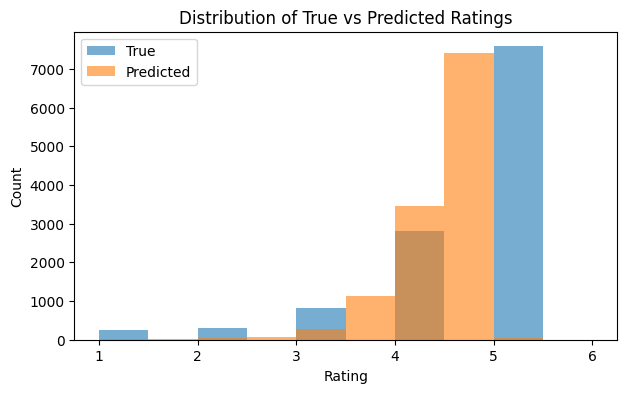

In [243]:
# histogram of our model's predictions
plt.figure(figsize=(7, 4))
plt.hist(y_test, bins=np.arange(1, 6.5, 0.5), alpha=0.6, label="True")
plt.hist(test_preds, bins=np.arange(1, 6.5, 0.5), alpha=0.6, label="Predicted")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of True vs Predicted Ratings")
plt.legend()
plt.show()

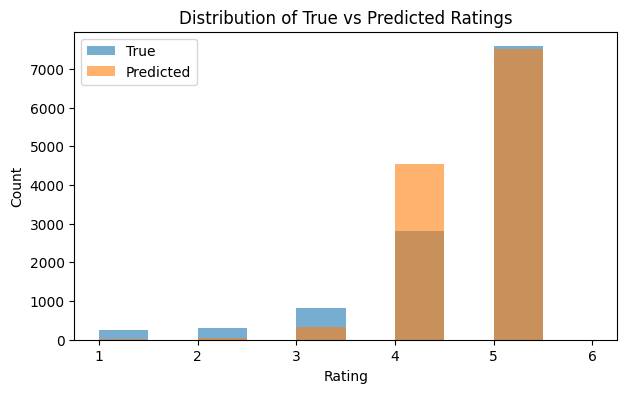

In [251]:
# histogram of our model's predictions
plt.figure(figsize=(7, 4))
plt.hist(y_test, bins=np.arange(1, 6.5, 0.5), alpha=0.6, label="True")
plt.hist(test_preds2, bins=np.arange(1, 6.5, 0.5), alpha=0.6, label="Predicted")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of True vs Predicted Ratings")
plt.legend()
plt.show()

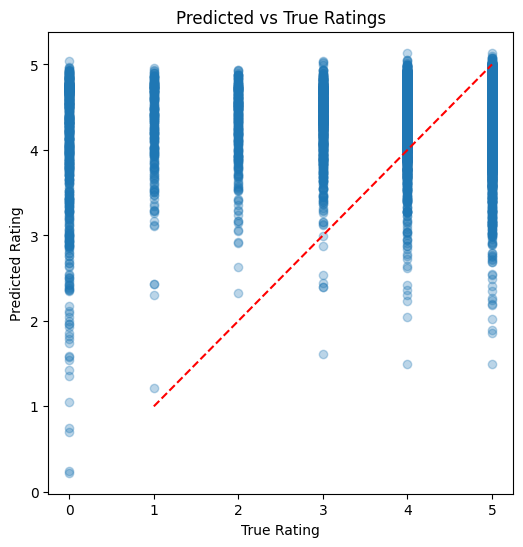

In [244]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_preds, alpha=0.3)
plt.plot([1, 5], [1, 5], 'r--')  # perfect prediction line
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs True Ratings")
plt.show()

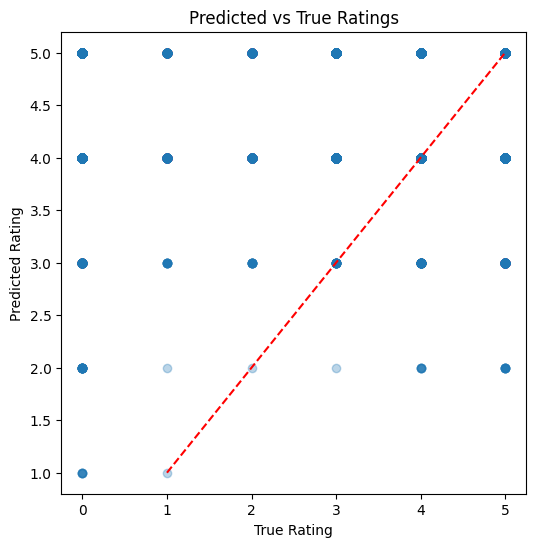

In [252]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_preds2, alpha=0.3)
plt.plot([1, 5], [1, 5], 'r--')  # perfect prediction line
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs True Ratings")
plt.show()

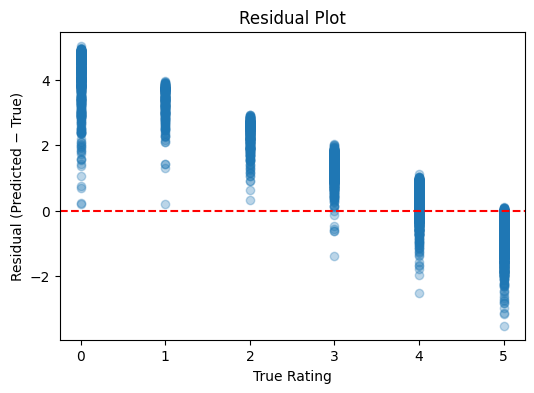

In [245]:
residuals = test_preds - y_test

plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Rating")
plt.ylabel("Residual (Predicted − True)")
plt.title("Residual Plot")
plt.show()

In [ ]:
residuals2 = test_preds2 - y_test

plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals2, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Rating")
plt.ylabel("Residual (Predicted − True)")
plt.title("Residual Plot")
plt.show()

NameError: name 'test_preds2' is not defined

# Section 5: Discussion of Related Work

### How Prior Work Has Approached Similar Tasks

In an earlier assignment, we approached the same type of **rating-prediction problem** using the Goodreads book-rating dataset. In that project, lots of students used a **latent factor model (LFM)** with:

- a global bias,
- user biases,
- item biases,
- and a learned user–item interaction term.

The prediction rule was:
$\hat{r}_{ui} = \alpha + b_u + b_i + g_u \, g_i$

The model was trained using **stochastic gradient descent** with regularization and early stopping.

This method reflects a standard pattern in recommender systems: combining global averages, user/item effects, and low-dimensional latent factors to capture preference structure. The success of this simple but powerful model highlights a recurring theme: **bias terms and lightweight latent factors can perform strongly even before introducing more complex models.**
 
 ---

### Example 1 of a project using Food.com Dataset

A Kaggle notebook using this same Food.com dataset builds a **popularity-based recipe recommender** by combining information from `RAW_recipes` and `RAW_interactions`.

https://www.kaggle.com/code/ngohoantamhuy/food-recommendation-systems


- **Data Cleaning:**  
  The interactions data is filtered to keep only `recipe_id` and `rating`, removing unneeded fields.

- **Aggregation:**  
  All ratings for each recipe are grouped to compute:
  - the **average rating**, and  
  - the **number of votes** per recipe.

- **Merging With Recipe Metadata:**  
  These statistics are merged back into the recipes table so each recipe now includes both its content features and its rating statistics.

- **Weighted Rating Score:**  
  To avoid giving small, perfectly-rated recipes too much influence, the project uses an **IMDB-style weighted rating formula**, which balances:
  - the recipe’s average rating,
  - the global mean rating across all recipes,
  - and the recipe’s number of ratings.

- **Outcome:**  
  Using this weighted score, the notebook identifies the **highest-rated** and **most widely appreciated** recipes.  
  This demonstrates how the dataset can support a **simple, interpretable recommender system** based purely on rating behavior and recipe metadata without personalization or machine-learning models.


---




### Example 2 of project using Food.com Dataset
A related project by **Estrada, Nguyen, and Singh** uses the same Food.com recipes and interactions dataset to build a **multi-class classification system** that predicts a recipe’s star rating directly from **text reviews and recipe attributes**. Their work explores several modeling approaches—regularized linear models, random forests, and neural networks—and evaluates how well different feature sets predict rating categories.

https://github.com/jimmy-nguyen-data-science/Predict-Food-Recipe-Ratings

### Summary of Their Final Report

#### 1. Text-Only Classification
Their analysis begins with using **TF–IDF features** extracted from review text.  
Using **L1/L2-regularized logistic regression with SGD**, they achieve **~72–73% accuracy** on the 5-class rating prediction task.

They then add recipe-side features:
- ingredients  
- nutrition values  
- number of steps  
- cook time  

However, these additional features **lower accuracy by ~3 percentage points**, suggesting that high-dimensional recipe metadata introduces noise that linear models struggle to handle.

#### 2. Random Forests and Neural Networks
They next try **Random Forests**, which again achieve **~72% accuracy** with 10-fold cross-validation.

Finally, they build a **neural network** that merges recipe and interaction features.  
Results:
- Balanced labels → **18% accuracy**  
- Unbalanced labels → **~72%**, matching simpler models  

The conclusion: even more complex models do **not** easily outperform a well-tuned linear baseline on this dataset.


### How Our Results Compare to This Related Work

Our project focuses on **regression-based rating prediction**, experimenting with:

- Global/user/recipe mean baselines  
- Ridge regression  
- k-Nearest Neighbors  
- Latent Factor Models (matrix factorization)

In contrast, the related paper frames the problem as **classification** using review text.  
Despite these differences, we find several shared themes:


#### 1. Both Projects Show That Simple Models Perform Surprisingly Well
- Their TF–IDF logistic regression reaches **~72%**.  
- Our mean-based baselines also perform strongly and serve as dependable comparison points.


#### 2. Adding More Features Does Not Always Improve Performance
- Their accuracy decreases when adding recipe metadata.  
- In our project, recipe embeddings or richer user features help only when carefully tuned; otherwise, they introduce noise or lead to overfitting.


#### 3. High-Capacity Models Do Not Automatically Outperform Baselines
- Their neural network does **not** outperform their linear model.  
- Our latent factor models often match or beat more complex approaches unless hyperparameters are finely tuned.

